# 3η Υποχρεωτική Εργασία
## Περιγραφή:
#### Να γραφεί πρόγραμμα σε οποιαδήποτε γλώσσα προγραμματισμού το οποίο να υλοποιεί ένα Radial Basis Function Neural Network (RBFNN) που θα εκπαιδευτεί για να επιλύει ένα από τα προβλήματα που επιλύσατε στις προηγούμενες εργασίες σας ή αντίστοιχο πρόβλημα προσέγγισης συνάρτησης ή ανακατασκευή δεδομένων.
#### Το θέμα που επιλέχθηκε είναι: MNIST Digit Classification
<a href="https://towardsdatascience.com/most-effective-way-to-implement-radial-basis-function-neural-network-for-classification-problem-33c467803319">Πηγή Αναφοράς</a>

### Imports
Σε αυτό το cell έχουμε όλα τα imports που θα χρειαστούμε στο notebook.

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.datasets import mnist
from keras.utils import np_utils
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import time

#in order to reproduce the same results every time
tf.random.set_seed(7)
RANDOM_STATE = 42

<h3>Φορτώνουμε το σύνολο δεδομένων μέσα από το Keras.</h3>
<p>Το Training set αποτελείται 60k εικόνες και το Test set αποτελείται από 10k εικόνες.</p>
<p>Κάθε εικόνα έχει διστάσεις 28x28 pixels σε Grayscale (δηλαδή έχουμε 1 channel, σε αντίθεση με το rgb που έχει 3 channels) και το label κάθε εικόνας είναι ο αριθμός που αυτή αναπαριστά (δηλαδή το label είναι ένας ακέραιος από το 0 έως το 9).</p>
<p>Κάθε pixel παίρνει τιμή από 0 έως 255, 0 για τα άσπρα pixels και 255 για τα μαύρα pixels</p>

In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(Y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(Y_test.shape))
print("Labels: " + str(np.unique(Y_train))) #μοναδικές τιμές του Y_train (προφανώς έχουμε τις ίδιες μοναδικές τιμές και στο Y_test)

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)
Labels: [0 1 2 3 4 5 6 7 8 9]


### Προετοιμασία των Data για να τα δώσουμε στη συνέχεια στα μοντέλα.

#### Κάθε training example είναι στη μορφή ενός δισδιάστατου πίνακα διαστάσεων 28x28. Επειδή δεν μπορούμε να τροφοδοτήσουμε τα δεδομένα στα μοντέλα μας με αυτήν τη δισδιάστατη μορφή, μετασχηματίζουμε κάθε training example ώστε να έχει τη μορφή ενός διανύσματος(one dimension array).

In [3]:
# Flattening
X_train = X_train.reshape((-1,28*28))
X_test = X_test.reshape((-1, 28*28))
print('X_train: ' + str(X_train.shape))
print('X_test: ' + str(X_test.shape))

X_train: (60000, 784)
X_test: (10000, 784)


#### Κανονικοποίηση των Δεδομένων (Data Scaling)
- Σε όλα τα πειράματα μας θα χρησιμοποιήσουμε τα κανονικοποιημένα δεδομένα μιας και δουλεύουμε με έναν τύπο μηχανής (RBF NN) που είναι distance-based.

In [4]:
# Normalization
X_train_Normalization = X_train / 255.0
X_test_Normalization= X_test / 255.0
num_of_training_samples = 10000

#### One hot encoding (OHE) των targets

In [5]:
Y_train_OHE = np_utils.to_categorical(Y_train, 10)
Y_test_OHE = np_utils.to_categorical(Y_test, 10)

# Περιεχόμενα του notebook
## 1. Διαφορετικά πλάτη στη συνάρτηση Gauss
## 2. Διαφορετικές αρχικοποιήσεις στα κέντρα των Gaussian RBF νευρώνων του κρυφού στρώματος
## 3. Extreme Learning Machine (ELM)
## 4. Σύγκριση RBF με KNN, Nearest Class Centroid και MLP
## 5. Χαρακτηριστικά παραδείγματα ορθής και εσφαλμένης κατηγοριοποίησης

# 1. Διαφορετικά πλάτη στη συνάρτηση Gauss
- Υπάρχουν δύο προσεγγίσεις για τον προσδιορισμό των πλατών (standard deviations) των συναρτήσεων ακτινικής βάσης σε ένα νευρωνικό δίκτυο RBF.
    1. Η πρώτη προσέγγιση είναι να οριστεί η τυπική απόκλιση κάθε συνάρτησης ακτινικής βάσης ως η τυπική απόκλιση των σημείων που έχουν αντιστοιχιστεί στο αντίστοιχο cluster. Με άλλα λόγια, το πλάτος της συνάρτησης ακτινικής βάσης καθορίζεται με βάση το spread των δεδομένων γύρω από το κεντρικό σημείο του cluster. Σε αυτήν την περίπτωση, κάθε RBF νευρώνας έχει το δικό του πλάτος.
    2. Η δεύτερη προσέγγιση είναι να χρησιμοποιήσουμε ίδια πλάτη (standard deviation) για όλους τους RBF νευρώνες. Σε αυτήν την περίπτωση, το standard deviation υπολογίζεται με βάση την maximum απόσταση ανάμεσα σε οποιαδήποτε δύο cluster centers και στο πλήθος των cluster centers (βλ. τον ακριβή τύπο επάνω).

### Η παρακάτω κλάση υλοποιεί ένα RBF δίκτυο το όποιο έχει αυτο-οργανωμένο κρυφό επίπεδο (με χρήση k-means clustering), δίνει δύο επιλογές για τα πλάτη των RBF νευρώνων και εκπαιδεύεται με την τεχνική "least squares" και με χρήση του "Penrose inverse" που ορίζεται ως εξής:  `A^+ = (A^T * A)^(-1) * A^T)`

Χρησιμοποιείται Gaussian RBF, όπως ορίζεται παρακάτω:

<img alt="" class="bf hu hv c" width="145" height="56" loading="lazy" role="presentation" src="https://miro.medium.com/max/145/1*MIay3aIlpT18yewOfnvTiQ.png">

Για την υπέρ-παράμετρο β, δίνονται δύο επιλογές:

1. Με χρήση του standard deviation του κάθε cluster (std_from_clusters=True):
<img alt="" class="bf hu hv c" width="290" height="93" loading="lazy" role="presentation" src="https://miro.medium.com/max/290/1*7CVXm8FYPF8CFudZBs_gJg.png">

2. με χρήση του παρακάτω τύπου (std_from_clusters=False):
<img alt="" class="bf hu hv c" width="304" height="102" loading="lazy" role="presentation" src="https://miro.medium.com/max/304/1*YEcI_P6orY917fQrzHQEjQ.png">

In [7]:
class RBFNN1:
    def __init__(self, X, y, k, std_from_clusters=True):
        self.std_list = None
        self.centroids = None
        self.w = None
        self.X = X
        self.y = y
        self.k = k
        self.std_from_clusters = std_from_clusters

    '''K means clustering for computing centroids and also calculates std of each RBF function'''
    def kmeans_clustering(self, X, k, std_from_clusters):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)

        # Fit the model to the data
        kmeans.fit(X)

        # Get the cluster centers
        centroids = kmeans.cluster_centers_

        if std_from_clusters: # Get the standard deviations of the clusters
            std_list = [np.std(X[kmeans.labels_ == i]) for i in range(k)]
        else:
            dMax = np.max([np.linalg.norm(c1 - c2) for c1 in centroids for c2 in centroids])
            std_list = np.repeat(dMax / np.sqrt(2 * k), k)

        return centroids,std_list

    '''Calculates the Euclidean distance between the data point x and the center point c, and then uses this distance to calculate the output of the Gaussian radial basis function. The standard deviation s determines the width of the Gaussian.'''
    def gaussian_rbf(self, x, c, s):
        distance = np.linalg.norm(x - c)
        return np.exp(-distance**2 / (2 * s**2))

    '''Calculates the output of each radial basis function using the gaussian_rbf function'''
    def rbf_list(self, X, centroids, std_list):
        rbf_list = []
        for x in X:
            rbf_list.append([self.gaussian_rbf(x, c, s) for (c, s) in zip(centroids, std_list)])
        return np.array(rbf_list)

    '''Converts the labels to one hot encoding vectors'''
    def convert_to_one_hot(self, x, num_of_classes):
        arr = np.zeros((len(x), num_of_classes))
        for i in range(len(x)):
            c = int(x[i])
            arr[i][c] = 1
        return arr

    def fit(self):
        # Calculate the cluster centers and standard deviations using k-means
        self.centroids, self.std_list = self.kmeans_clustering(self.X, self.k, self.std_from_clusters)

        # num of different classes
        num_of_classes = len(np.unique(self.y))

        # Calculate the outputs of the radial basis functions
        RBF_X = self.rbf_list(self.X, self.centroids, self.std_list)

        # Calculate the weights of the output layer using "least squares"
        self.w = np.linalg.pinv(RBF_X.T @ RBF_X) @ RBF_X.T @ self.convert_to_one_hot(self.y, num_of_classes)

    def predict(self,X_test):
        # Calculate the outputs of the radial basis functions
        RBF_X = self.rbf_list(X_test, self.centroids, self.std_list)

        # Calculate the output of the network
        predictions = RBF_X @ self.w

        # return the predictions of the network (in form of labels and not as One Hot vectors)
        return np.array([np.argmax(x) for x in predictions])


## Εκπαίδευση με την πρώτη προσέγγιση:

In [155]:
# Create an instance of the RBFNN class
rbf_std_from_clusters = RBFNN1(X_train_Normalization, Y_train, k=100, std_from_clusters=True)

# Fit the model to the training data
start_time = time.time()
rbf_std_from_clusters.fit()
end_time = time.time()
total_time_fit = end_time - start_time

# Make predictions on the test data
start_time = time.time()
rbf_std_from_clusters_predictions = rbf_std_from_clusters.predict(X_test_Normalization)
end_time = time.time()
total_time_predict = end_time - start_time

In [162]:
print(f"Χρόνος εκπαίδευσης: {total_time_fit} seconds.")
print(f"Χρόνος για predictions: {total_time_predict} seconds.")
print('Accuracy on Train: ', accuracy_score(Y_train, rbf_std_from_clusters.predict(X_train_Normalization)))
print('Accuracy on Test: ', accuracy_score(Y_test, rbf_std_from_clusters_predictions))

Χρόνος εκπαίδευσης: 176.62787246704102 seconds.
Χρόνος για predictions: 7.034318447113037 seconds.
Accuracy on Train:  0.21801666666666666
Accuracy on Test:  0.2196


## Εκπαίδευση με την δεύτερη προσέγγιση:

In [159]:
# Create an instance of the RBFNN class
rbf_same_std = RBFNN1(X_train_Normalization, Y_train, k=100, std_from_clusters=False)

# Fit the model to the training data
start_time = time.time()
rbf_same_std.fit()
end_time = time.time()
total_time_fit = end_time - start_time

# Make predictions on the test data
start_time = time.time()
rbf_same_std_predictions = rbf_same_std.predict(X_test_Normalization)
end_time = time.time()
total_time_predict = end_time - start_time

In [163]:
print(f"Χρόνος εκπαίδευσης: {total_time_fit} seconds.")
print(f"Χρόνος για predictions: {total_time_predict} seconds.")
print('Accuracy on Train: ', accuracy_score(Y_train, rbf_same_std.predict(X_train_Normalization)))
print('Accuracy on Test: ', accuracy_score(Y_test, rbf_same_std_predictions))

Χρόνος εκπαίδευσης: 176.62787246704102 seconds.
Χρόνος για predictions: 7.034318447113037 seconds.
Accuracy on Train:  0.8501833333333333
Accuracy on Test:  0.8552


### Παρατηρήσεις:
- Παρατηρούμε ότι η πρώτη προσέγγιση αδυνατεί να μάθει το task πετυχαίνοντας πάρα πολύ low accuracy. Αντίθετα, με τη δεύτερη προσέγγιση παρατηρούμε ότι το μοντέλο μαθαίνει το task πετυχαίνοντας ένα ικανοποιητικό accuracy.
- Αυτό μπορεί να οφείλεται στα παρακάτω:
    1. If the points within a cluster are widely dispersed, the standard deviation of the cluster will be large, which could cause the radial basis function to be too wide and not accurately capture the structure of the data.
    2. The number of clusters (k) could be too small or too large. If k is too small, the model may not be able to capture the complexity of the data and will have low accuracy.
    3. The choice of distance metric could also impact the model's accuracy. The Euclidean distance metric used in the implementation may not be the best choice for the given dataset.

Ας ελέγξουμε μήπως το πλήθος των clusters ήταν το πρόβλημα της πρώτης προσέγγισης, αυξάνοντας το k από 100 σε 1000.

In [164]:
# Create an instance of the RBFNN class
rbf_std_from_clusters = RBFNN1(X_train_Normalization, Y_train, k=1000, std_from_clusters=True)

# Fit the model to the training data
start_time = time.time()
rbf_std_from_clusters.fit()
end_time = time.time()
total_time_fit = end_time - start_time

# Make predictions on the test data
start_time = time.time()
rbf_std_from_clusters_predictions = rbf_std_from_clusters.predict(X_test_Normalization)
end_time = time.time()
total_time_predict = end_time - start_time

In [165]:
print(f"Χρόνος εκπαίδευσης: {total_time_fit} seconds.")
print(f"Χρόνος για predictions: {total_time_predict} seconds.")
print('Accuracy on Train: ', accuracy_score(Y_train, rbf_std_from_clusters.predict(X_train_Normalization)))
print('Accuracy on Test: ', accuracy_score(Y_test, rbf_std_from_clusters_predictions))

Χρόνος εκπαίδευσης: 1296.758367061615 seconds.
Χρόνος για predictions: 70.11491441726685 seconds.
Accuracy on Train:  0.23566666666666666
Accuracy on Test:  0.2366


- Παρατηρούμε ότι έχουμε πολύ μικρή βελτίωση, παρόλο που αυξήσαμε το πλήθος των clusters από 100 σε 1000.

# 2. Διαφορετικές αρχικοποιήσεις στα κέντρα των Gaussian RBF νευρώνων του κρυφού στρώματος
- θα εξετάσουμε 2 περιπτώσεις:
    1. 100 κρυφοί νευρώνες
    2. 10 κρυφοί νευρώνες
- Σε κάθε μία από αυτές τις περιπτώσεις θα αρχικοποιήσουμε τα κέντρα με (i) τυχαία δείγματα του Data Set, με (ii) τυχαία δείγματα από κάθε κλάση, με (iii) αυτό-οργάνωση (clustering).
- Σε κάθε ένα από τα παρακάτω πειράματα έχουμε χρησιμοποιήσει ίσα πλάτη(όπως αυτά προκύπτουν από την εξίσωση που βλέπουμε παρακάτω):
<img alt="" class="bf hu hv c" width="304" height="102" loading="lazy" role="presentation" src="https://miro.medium.com/max/304/1*YEcI_P6orY917fQrzHQEjQ.png">

## 1η περίπτωση, με 100 κρυφούς νευρώνες.

### (i) τυχαία δείγματα του Data Set

#### Η κλάση αυτή είναι τροποποίηση της RBFNN1 (προηγούμενης κλάσης) για να εξυπηρετεί το τρέχον πείραμα.

In [8]:
class RBFNN2:
    def __init__(self, X, y, k):
        self.std_list = None
        self.centroids = None
        self.w = None
        self.X = X
        self.y = y
        self.k = k

    '''k randoms vectors from Data Set used for centroids and also calculates std of each RBF function'''
    def calculate_centroids_std(self, X, k):
        # Get the RBF centers
        centroids = X[np.random.choice(X.shape[0], k, replace=False), :]

        dMax = np.max([np.linalg.norm(c1 - c2) for c1 in centroids for c2 in centroids])
        std_list = np.repeat(dMax / np.sqrt(2 * k), k)

        return centroids,std_list

    '''Calculates the Euclidean distance between the data point x and the center point c, and then uses this distance to calculate the output of the Gaussian radial basis function. The standard deviation s determines the width of the Gaussian.'''
    def gaussian_rbf(self, x, c, s):
        distance = np.linalg.norm(x - c)
        return np.exp(-distance**2 / (2 * s**2))

    '''Calculates the output of each radial basis function using the gaussian_rbf function'''
    def rbf_list(self, X, centroids, std_list):
        rbf_list = []
        for x in X:
            rbf_list.append([self.gaussian_rbf(x, c, s) for (c, s) in zip(centroids, std_list)])
        return np.array(rbf_list)

    '''Converts the labels to one hot encoding vectors'''
    def convert_to_one_hot(self, x, num_of_classes):
        arr = np.zeros((len(x), num_of_classes))
        for i in range(len(x)):
            c = int(x[i])
            arr[i][c] = 1
        return arr

    def fit(self):
        # Calculate the cluster centers and standard deviations
        self.centroids, self.std_list = self.calculate_centroids_std(self.X, self.k)

        # num of different classes
        num_of_classes = len(np.unique(self.y))

        # Calculate the outputs of the radial basis functions
        RBF_X = self.rbf_list(self.X, self.centroids, self.std_list)

        # Calculate the weights of the output layer using "least squares"
        self.w = np.linalg.pinv(RBF_X.T @ RBF_X) @ RBF_X.T @ self.convert_to_one_hot(self.y, num_of_classes)

    def predict(self,X_test):
        # Calculate the outputs of the radial basis functions
        RBF_X = self.rbf_list(X_test, self.centroids, self.std_list)

        # Calculate the output of the network
        predictions = RBF_X @ self.w

        # return the predictions of the network (in form of labels and not as One Hot vectors)
        return np.array([np.argmax(x) for x in predictions])


In [9]:
# Τυχαία επιλογή δειγμάτων από το Data Set ως centroids
rbf_random_centroids = RBFNN2(X_train_Normalization, Y_train, k=100)

# Fit the model to the training data
start_time = time.time()
rbf_random_centroids.fit()
end_time = time.time()
total_time_fit = end_time - start_time

# Make predictions on the test data
start_time = time.time()
rbf_random_centroids_predictions = rbf_random_centroids.predict(X_test_Normalization)
end_time = time.time()
total_time_predict = end_time - start_time

In [10]:
print(f"Χρόνος εκπαίδευσης: {total_time_fit} seconds.")
print(f"Χρόνος για predictions: {total_time_predict} seconds.")
print('Accuracy on Train: ', accuracy_score(Y_train, rbf_random_centroids.predict(X_train_Normalization)))
print('Accuracy on Test: ', accuracy_score(Y_test, rbf_random_centroids_predictions))

Χρόνος εκπαίδευσης: 42.458271741867065 seconds.
Χρόνος για predictions: 6.826105356216431 seconds.
Accuracy on Train:  0.70565
Accuracy on Test:  0.7099


Text(0.5, 1.0, 'Πλήθος παραδειγμάτων ανά κλάση')

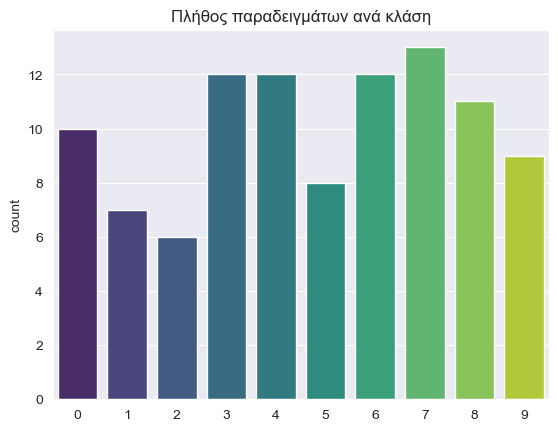

In [11]:
indices = np.where((X_train_Normalization == rbf_random_centroids.centroids[:, None]).all(-1))[1]
sns.countplot(x = Y_train[indices], palette = "viridis")
plt.title("Πλήθος παραδειγμάτων ανά κλάση")

Text(0.5, 1.0, 'Confusion Matrix')

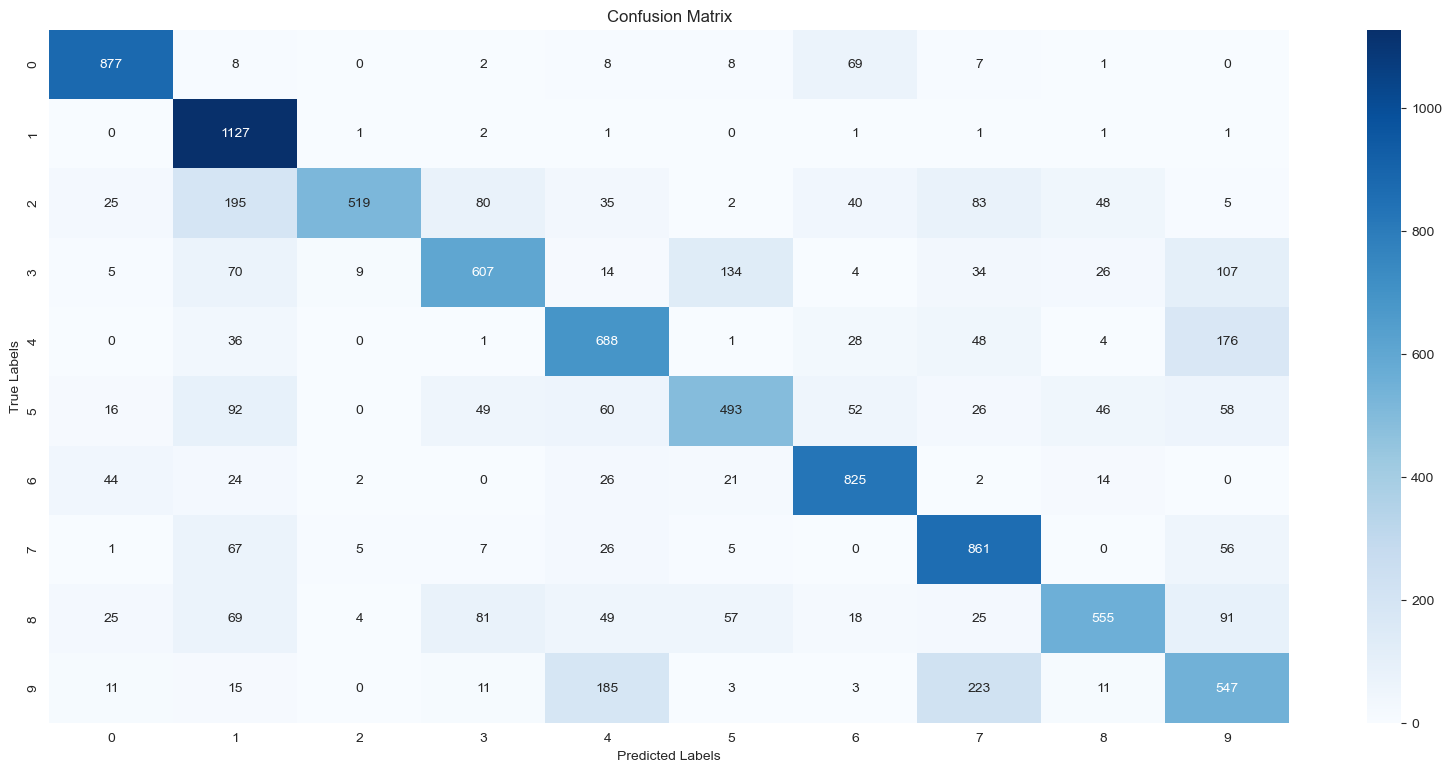

In [14]:
conf_matrix = confusion_matrix(Y_test, rbf_random_centroids_predictions)
plt.figure(figsize=(20,9))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.title("Confusion Matrix")

### (ii) τυχαία δείγματα από κάθε κλάση

#### Η κλάση αυτή είναι τροποποίηση της RBFNN1 για να εξυπηρετεί το τρέχον πείραμα.

In [12]:
class RBFNN3:
    def __init__(self, X, y, k):
        self.std_list = None
        self.centroids = None
        self.w = None
        self.X = X
        self.y = y
        self.k = k

    '''k instances of each class used for centroids and also calculates std of each RBF function'''
    def calculate_centroids_std(self, X, k):

        """W keep 10 training examples of each class"""
        # Get the unique class values
        unique_classes = np.unique(self.y)
        num_of_classes = unique_classes.shape[0]

        # Initialize a list to store the indices of the training examples for each class
        indices = []
        self.Y_subset = []

        # Loop over the unique class values
        for c in unique_classes:
            # Find the indices of the training examples with class value c
            idx = np.where(self.y == c)[0]
            # Keep the first 10 indices
            indices.append(idx[:k])
            self.Y_subset.append(self.y[idx[:k]])

        # Flatten the list of indices
        indices = np.concatenate(indices)
        self.Y_subset = np.concatenate(self.Y_subset)

        # Select the training examples at the indices
        centroids = X[indices]

        dMax = np.max([np.linalg.norm(c1 - c2) for c1 in centroids for c2 in centroids])
        std_list = np.repeat(dMax / np.sqrt(2 * num_of_classes * k), num_of_classes * k)

        return centroids,std_list

    '''Calculates the Euclidean distance between the data point x and the center point c, and then uses this distance to calculate the output of the Gaussian radial basis function. The standard deviation s determines the width of the Gaussian.'''
    def gaussian_rbf(self, x, c, s):
        distance = np.linalg.norm(x - c)
        return np.exp(-distance**2 / (2 * s**2))

    '''Calculates the output of each radial basis function using the gaussian_rbf function'''
    def rbf_list(self, X, centroids, std_list):
        rbf_list = []
        for x in X:
            rbf_list.append([self.gaussian_rbf(x, c, s) for (c, s) in zip(centroids, std_list)])
        return np.array(rbf_list)

    '''Converts the labels to one hot encoding vectors'''
    def convert_to_one_hot(self, x, num_of_classes):
        arr = np.zeros((len(x), num_of_classes))
        for i in range(len(x)):
            c = int(x[i])
            arr[i][c] = 1
        return arr

    def fit(self):
        # Calculate the cluster centers and standard deviations
        self.centroids, self.std_list = self.calculate_centroids_std(self.X, self.k)

        # num of different classes
        num_of_classes = len(np.unique(self.y))

        # Calculate the outputs of the radial basis functions
        RBF_X = self.rbf_list(self.X, self.centroids, self.std_list)

        # Calculate the weights of the output layer using "least squares"
        self.w = np.linalg.pinv(RBF_X.T @ RBF_X) @ RBF_X.T @ self.convert_to_one_hot(self.y, num_of_classes)

    def predict(self,X_test):
        # Calculate the outputs of the radial basis functions
        RBF_X = self.rbf_list(X_test, self.centroids, self.std_list)

        # Calculate the output of the network
        predictions = RBF_X @ self.w

        # return the predictions of the network (in form of labels and not as One Hot vectors)
        return np.array([np.argmax(x) for x in predictions])

In [260]:
# Επιλογή 10 training examples από κάθε κλάση ως centroids
rbf_equally_chosen_instances = RBFNN3(X_train_Normalization, Y_train, k=10)

# Fit the model to the training data
start_time = time.time()
rbf_equally_chosen_instances.fit()
end_time = time.time()
total_time_fit = end_time - start_time

# Make predictions on the test data
start_time = time.time()
rbf_equally_chosen_instances_predictions = rbf_equally_chosen_instances.predict(X_test_Normalization)
end_time = time.time()
total_time_predict = end_time - start_time

In [261]:
print(f"Χρόνος εκπαίδευσης: {total_time_fit} seconds.")
print(f"Χρόνος για predictions: {total_time_predict} seconds.")
print('Accuracy on Train: ', accuracy_score(Y_train, rbf_equally_chosen_instances.predict(X_train_Normalization)))
print('Accuracy on Test: ', accuracy_score(Y_test, rbf_equally_chosen_instances_predictions))

Χρόνος εκπαίδευσης: 48.95271944999695 seconds.
Χρόνος για predictions: 8.02380633354187 seconds.
Accuracy on Train:  0.6929
Accuracy on Test:  0.6898


Text(0.5, 1.0, 'Πλήθος παραδειγμάτων ανά κλάση')

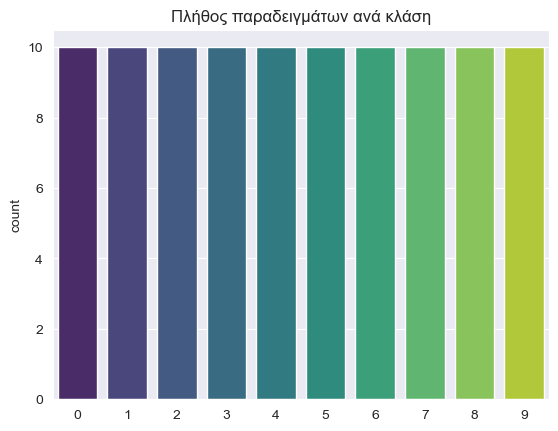

In [262]:
# Plot the counts of the labels in Y_train at the indices
sns.countplot(x=rbf_equally_chosen_instances.Y_subset, palette="viridis")
plt.title("Πλήθος παραδειγμάτων ανά κλάση")

### (iii) αυτό-οργάνωση (clustering)

In [15]:
# Αυτό-οργάνωση του κρυφού στρώματος με clustering
rbf_clustering = RBFNN1(X_train_Normalization, Y_train, k=100, std_from_clusters=False)

# Fit the model to the training data
start_time = time.time()
rbf_clustering.fit()
end_time = time.time()
total_time_fit = end_time - start_time

# Make predictions on the test data
start_time = time.time()
rbf_clustering_predictions = rbf_clustering.predict(X_test_Normalization)
end_time = time.time()
total_time_predict = end_time - start_time

In [16]:
print(f"Χρόνος εκπαίδευσης: {total_time_fit} seconds.")
print(f"Χρόνος για predictions: {total_time_predict} seconds.")
print('Accuracy on Train: ', accuracy_score(Y_train, rbf_clustering.predict(X_train_Normalization)))
print('Accuracy on Test: ', accuracy_score(Y_test, rbf_clustering_predictions))

Χρόνος εκπαίδευσης: 187.50640559196472 seconds.
Χρόνος για predictions: 6.86669921875 seconds.
Accuracy on Train:  0.8464666666666667
Accuracy on Test:  0.8503


### Παρατηρήσεις:
- Η αυτό-οργάνωση του κρυφού επιπέδου με clustering πετυχαίνει πολύ καλύτερα αποτελέσματα σε σχέση με τις άλλες δύο περιπτώσεις με τον ίδιο αριθμό κρυφών νευρώνων στο RBF layer.
- Ενδιαφέρον έχει το γεγονός, πως στην τυχαία επιλογή δειγμάτων πετυχαίνουμε λίγο καλύτερα αποτελέσματα σε σχέση με την επιλογή ίδιο πλήθους training examples από κάθε κλάση ως centroids. Σε αυτό σημαντικό ρόλο παίζει πως από την τυχαία αυτή επιλογή κανένα μιά κλάση δεν έμεινε εκτός, όπως φαίνεται και από το plot.
- Παρατηρούμε ότι στην τυχαία επιλογή δειγμάτων ως centroids η κλάση η οποία εκπροσωπείται λιγότερο στο κρυφό στρώμα είναι τα "2", και από τον confusion matrix βλέπουμε πως πράγματι στην κλάση αυτή το μοντέλο δυσκολεύεται και κάνει αρκετά λάθη.
- Αναφορικά με τους χρόνους εκπαίδευσης, παρατηρούμε ότι η αυτό-οργάνωση είναι αρκετά πιο αργή (λόγω του clustering) σε σχέση με τα άλλα 2.
- Ο χρόνος πρόβλεψης όπως είναι και λογικό είναι ίδιος και στις τρεις περιπτώσεις.

## 2η περίπτωση, με 10 κρυφούς νευρώνες.

### (i) τυχαία δείγματα του Data Set

In [17]:
# Τυχαία επιλογή δειγμάτων από το Data Set ως centroids
rbf_random_centroids = RBFNN2(X_train_Normalization, Y_train, k=10)

# Fit the model to the training data
start_time = time.time()
rbf_random_centroids.fit()
end_time = time.time()
total_time_fit = end_time - start_time

# Make predictions on the test data
start_time = time.time()
rbf_random_centroids_predictions = rbf_random_centroids.predict(X_test_Normalization)
end_time = time.time()
total_time_predict = end_time - start_time

In [20]:
print(f"Χρόνος εκπαίδευσης: {total_time_fit} seconds.")
print(f"Χρόνος για predictions: {total_time_predict} seconds.")
print('Accuracy on Train: ', accuracy_score(Y_train, rbf_random_centroids.predict(X_train_Normalization)))
print('Accuracy on Test: ', accuracy_score(Y_test, rbf_random_centroids_predictions))

Χρόνος εκπαίδευσης: 4.480876445770264 seconds.
Χρόνος για predictions: 0.9076089859008789 seconds.
Accuracy on Train:  0.3736333333333333
Accuracy on Test:  0.3784


Text(0.5, 1.0, 'Πλήθος παραδειγμάτων ανά κλάση')

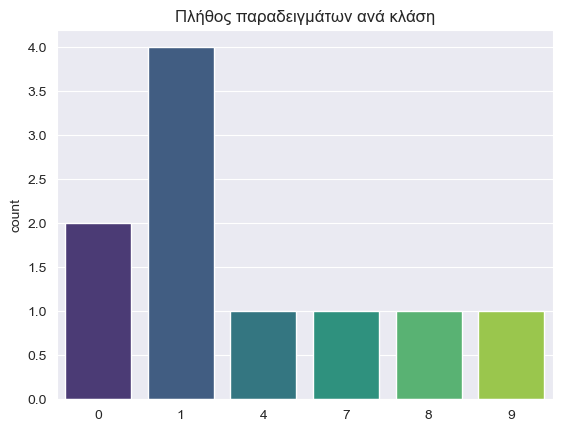

In [21]:
indices = np.where((X_train_Normalization == rbf_random_centroids.centroids[:, None]).all(-1))[1]
sns.countplot(x = Y_train[indices], palette = "viridis")
plt.title("Πλήθος παραδειγμάτων ανά κλάση")

Text(0.5, 1.0, 'Confusion Matrix')

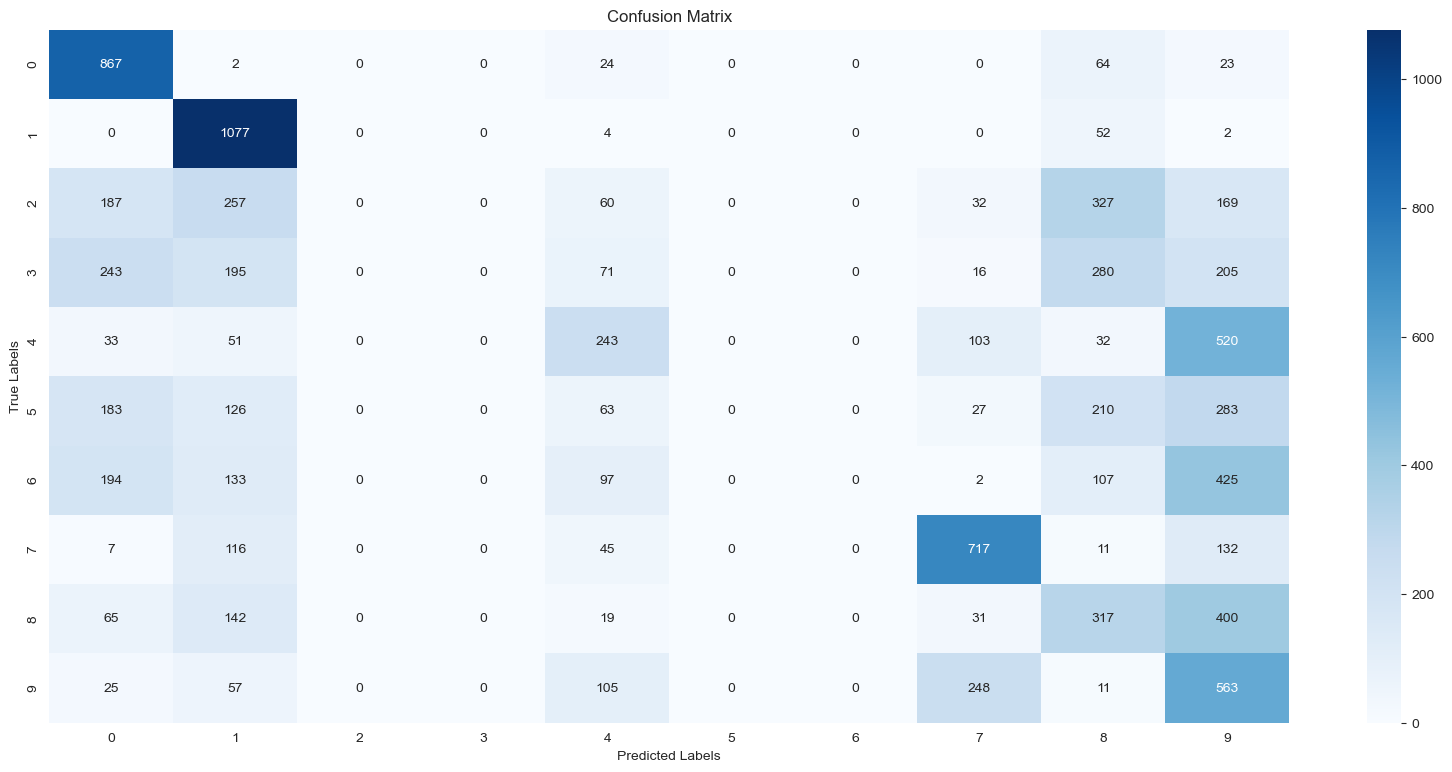

In [22]:
conf_matrix = confusion_matrix(Y_test, rbf_random_centroids_predictions)
plt.figure(figsize=(20,9))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.title("Confusion Matrix")

### (ii) τυχαία δείγματα από κάθε κλάση

In [23]:
# Επιλογή 10 training examples από κάθε κλάση ως centroids
rbf_equally_chosen_instances = RBFNN3(X_train_Normalization, Y_train, k=1)

# Fit the model to the training data
start_time = time.time()
rbf_equally_chosen_instances.fit()
end_time = time.time()
total_time_fit = end_time - start_time

# Make predictions on the test data
start_time = time.time()
rbf_equally_chosen_instances_predictions = rbf_equally_chosen_instances.predict(X_test_Normalization)
end_time = time.time()
total_time_predict = end_time - start_time

In [24]:
print(f"Χρόνος εκπαίδευσης: {total_time_fit} seconds.")
print(f"Χρόνος για predictions: {total_time_predict} seconds.")
print('Accuracy on Train: ', accuracy_score(Y_train, rbf_equally_chosen_instances.predict(X_train_Normalization)))
print('Accuracy on Test: ', accuracy_score(Y_test, rbf_equally_chosen_instances_predictions))

Χρόνος εκπαίδευσης: 4.301891565322876 seconds.
Χρόνος για predictions: 0.8601949214935303 seconds.
Accuracy on Train:  0.50855
Accuracy on Test:  0.4985


Text(0.5, 1.0, 'Confusion Matrix')

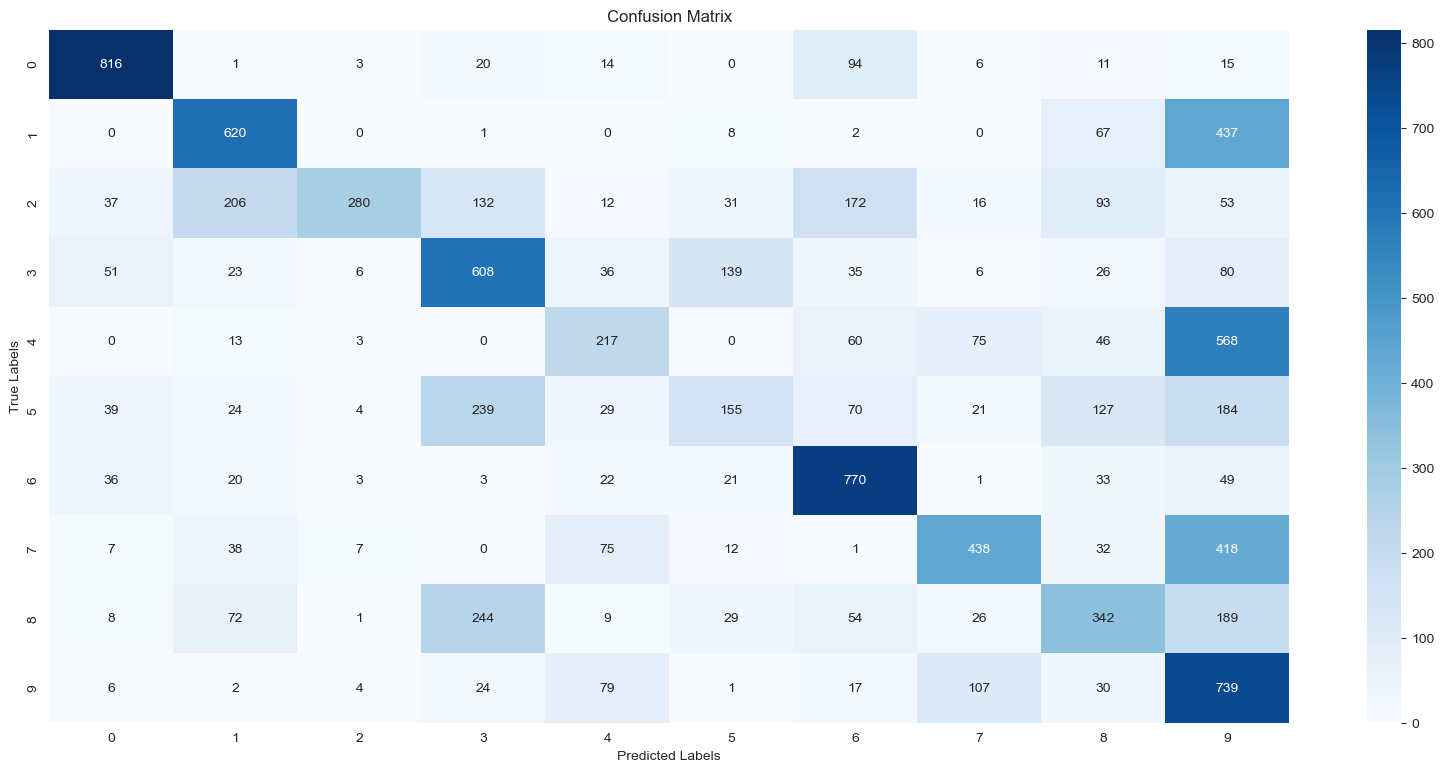

In [28]:
conf_matrix = confusion_matrix(Y_test, rbf_equally_chosen_instances_predictions)
plt.figure(figsize=(20,9))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.title("Confusion Matrix")

Text(0.5, 1.0, 'Πλήθος παραδειγμάτων ανά κλάση')

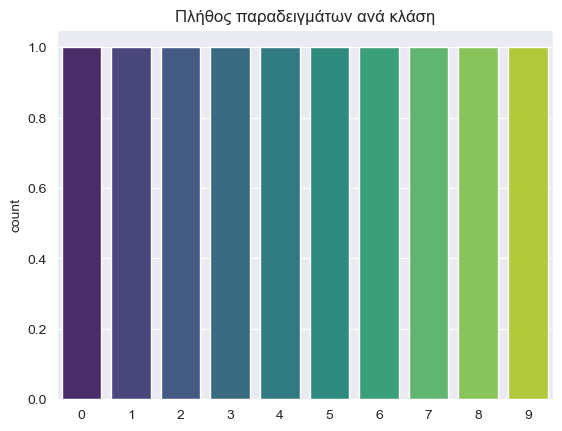

In [25]:
# Plot the counts of the labels in Y_train at the indices
sns.countplot(x=rbf_equally_chosen_instances.Y_subset, palette="viridis")
plt.title("Πλήθος παραδειγμάτων ανά κλάση")

### (iii) αυτό-οργάνωση (clustering)

In [26]:
# Αυτό-οργάνωση του κρυφού στρώματος με clustering
rbf_clustering = RBFNN1(X_train_Normalization, Y_train, k=10, std_from_clusters=False)

# Fit the model to the training data
start_time = time.time()
rbf_clustering.fit()
end_time = time.time()
total_time_fit = end_time - start_time

# Make predictions on the test data
start_time = time.time()
rbf_clustering_predictions = rbf_clustering.predict(X_test_Normalization)
end_time = time.time()
total_time_predict = end_time - start_time

In [27]:
print(f"Χρόνος εκπαίδευσης: {total_time_fit} seconds.")
print(f"Χρόνος για predictions: {total_time_predict} seconds.")
print('Accuracy on Train: ', accuracy_score(Y_train, rbf_clustering.predict(X_train_Normalization)))
print('Accuracy on Test: ', accuracy_score(Y_test, rbf_clustering_predictions))

Χρόνος εκπαίδευσης: 27.764058351516724 seconds.
Χρόνος για predictions: 0.7573411464691162 seconds.
Accuracy on Train:  0.6043
Accuracy on Test:  0.6099


- Παρατηρήσεις:
- Όπως ήταν αναμενόμενο ο χρόνος εκπαίδευσης και πρόβλεψης μειώθηκε και στις τρεις περιπτώσεις.
- Επίσης, μιας και μειώθηκε το capacity του δικτύου μειώθηκε και η ικανότητα του να μάθει το task. Για αυτό τον λόγο, και στις τρεις περιπτώσεις βλέπουμε μείωση στο accuracy.
- Η αυτό-οργάνωση πετυχαίνει και πάλι τα καλύτερα αποτελέσματα με την τυχαία επιλογή δειγμάτων ως centroids να είναι η χειρότερη σε αυτό το πείραμα. Το τελευταίο είναι απολύτως λογικό καθώς στο κρυφό στρώμα δεν έχουμε κανένα centroid των κλάσεων 2,3,5 και 6. Από τον confusion matrix βλέπουμε πως για τις προαναφερθείσες κλάσεις όχι μόνο δεν έκανε καμία σωστή πρόβλεψη, αλλά δεν κατηγοριοποίησε κανένα Test δείγμα σε κάποια από αυτές, αφού στο κρυφό στρώμα που χαρακτηρίζεται και ως "Representation Learning Layer" δεν εκπροσωπούνται αυτές οι κλάσεις και συνεπώς στον χώρο των ομοιοτήτων δεν υπάρχουν αυτές τις κλάσεις. Ενδιαφέρον έχει το γεγονός ότι στην περίπτωση της κλάσης "1", όπου έχει και τα περισσότερα κέντρα στο κρυφό layer, το δίκτυο πετυχαίνει πολύ ικανοποιητικές αποδόσεις καθώς είναι πιο confident όταν κάνει classify ένα δείγμα της κλάσης "1".
- Αναφορικά με την αρχικοποίηση των centroids από 10 τυχαία training examples (1 από κάθε κλάση), θα αναμέναμε το μοντέλο να τα καταφέρνει περίπου το ίδιο σε όλες τις κλάσεις. Κάτι τέτοιο, ωστόσο δε συμβαίνει με το μοντέλο να έχει καλύτερες επιδόσεις σε κάποιες κλάσεις σε σχέση με κάποιες άλλες. Για παράδειγμα, στην κλάση "5" έχει πολύ κακή επίδοση, ενδεχομένως επειδή το 5 που δόθηκε ως κέντρο να μην ήταν πολύ καλοσχηματισμένο και να μοιάζει πολύ με 3 (και έτσι πολλά 5 να γίνονται classify ως 3).

# 3. Extreme Learning Machine (ELM)
- θα προσπαθήσουμε σε αυτό το πείραμα να ορίσουμε μια Extreme Learning Machine, με αφορμή το γεγονός ότι σε προηγούμενο πείραμα η τυχαία επιλογή δειγμάτων ως κέντρα στους RBF νευρώνες είχε καλύτερη επίδοση, σε σχέση με την επιλογή ενός instance από κάθε κλάση ως κέντρο.
- Για να ορίσουμε μια ELM θα ορίσουμε 100 τυχαία κέντρα και 100 τυχαία standard deviations για τους RBF νευρώνες. Κρατώντας αυτές τις παραμέτρους των νευρώνων fix, θα βρούμε τα weights του output layer με "least squares".

#### Τροποποίηση της RBFNN1 για να μας εξυπηρετεί στο συγκεκριμένο πείραμα

In [54]:
class ELM:
    def __init__(self, X, y, k):
        self.std_list = None
        self.centroids = None
        self.w = None
        self.X = X
        self.y = y
        self.k = k

    '''k random for centroids and also calculates k random std for each RBF function'''
    def calculate_centroids_std(self, X, k):

        # Generate k random vectors of size X.shape[1] (eg. 784 for MNIST) each
        centroids = np.random.rand(k, X.shape[1])

        # Generate a vector of size 10 with the same random float (between 0 and 10 - more precisely [0,10)
        random_float = np.random.uniform(low=0, high=10 + 1e-10)
        std_list = np.repeat(random_float, k)

        return centroids,std_list

    '''Calculates the Euclidean distance between the data point x and the center point c, and then uses this distance to calculate the output of the Gaussian radial basis function. The standard deviation s determines the width of the Gaussian.'''
    def gaussian_rbf(self, x, c, s):
        distance = np.linalg.norm(x - c)
        return np.exp(-distance**2 / (2 * s**2))

    '''Calculates the output of each radial basis function using the gaussian_rbf function'''
    def rbf_list(self, X, centroids, std_list):
        rbf_list = []
        for x in X:
            rbf_list.append([self.gaussian_rbf(x, c, s) for (c, s) in zip(centroids, std_list)])
        return np.array(rbf_list)

    '''Converts the labels to one hot encoding vectors'''
    def convert_to_one_hot(self, x, num_of_classes):
        arr = np.zeros((len(x), num_of_classes))
        for i in range(len(x)):
            c = int(x[i])
            arr[i][c] = 1
        return arr

    def fit(self):
        # Calculate the cluster centers and standard deviations
        self.centroids, self.std_list = self.calculate_centroids_std(self.X, self.k)

        # num of different classes
        num_of_classes = len(np.unique(self.y))

        # Calculate the outputs of the radial basis functions
        RBF_X = self.rbf_list(self.X, self.centroids, self.std_list)

        # Calculate the weights of the output layer using "least squares"
        self.w = np.linalg.pinv(RBF_X.T @ RBF_X) @ RBF_X.T @ self.convert_to_one_hot(self.y, num_of_classes)

    def predict(self,X_test):
        # Calculate the outputs of the radial basis functions
        RBF_X = self.rbf_list(X_test, self.centroids, self.std_list)

        # Calculate the output of the network
        predictions = RBF_X @ self.w

        # return the predictions of the network (in form of labels and not as One Hot vectors)
        return np.array([np.argmax(x) for x in predictions])

In [59]:
# Extreme Learning Machine
rbf_elm = ELM(X_train_Normalization, Y_train, k=100)

# Fit the model to the training data
start_time = time.time()
rbf_elm.fit()
end_time = time.time()
total_time_fit = end_time - start_time

# Make predictions on the test data
start_time = time.time()
rbf_elm_predictions = rbf_elm.predict(X_test_Normalization)
end_time = time.time()
total_time_predict = end_time - start_time

In [60]:
print(f"Χρόνος εκπαίδευσης: {total_time_fit} seconds.")
print(f"Χρόνος για predictions: {total_time_predict} seconds.")
print('Accuracy on Train: ', accuracy_score(Y_train, rbf_elm.predict(X_train_Normalization)))
print('Accuracy on Test: ', accuracy_score(Y_test, rbf_elm_predictions))

Χρόνος εκπαίδευσης: 41.219772815704346 seconds.
Χρόνος για predictions: 6.947722434997559 seconds.
Accuracy on Train:  0.8228166666666666
Accuracy on Test:  0.829


#### Παρατηρήσεις:
- Παρατηρούμε ότι το ELM μοντέλο μας πλησιάζει αρκετά τις επιδόσεις του RBF με αυτό-οργανωμένο κρυφό layer, ενώ μάλιστα είναι αρκετά πιο γρήγορη η εκπαίδευση του.
- Το ELM μοντέλο ξεπερνάει (δεδομένου του ίδιου πλήθους νευρώνων στο κρυφό επίπεδο) και την περίπτωση όπου στο κρυφό επίπεδο επιλέγουμε τυχαία δείγματα αλλά και την περίπτωση όπου έχουμε τυχαία δείγματα από κάθε κλάση.

# 4. Σύγκριση RBF με KNN, Nearest Class Centroid και MLP
### Το RBF νευρωνικό δίκτυο μοιάζει με κάποιες μηχανές που έχουμε δει, όπως είναι ο KNN και ο NCC.
- Για παράδειγμα, εάν βάλουμε όλο το Data Set στο κρυφό layer ως κέντρα στους RBF νευρώνες προσομοιάζουμε τον KNN.
- Αντίστοιχα, εάν βάλουμε τα κέντρα του NCC ως κέντρα στους RBF νευρώνες, προσομοιάζουμε τον NCC.

<h3>K-Nearest Neighbors Classifier</h3>
<h4>Με 1 πλησιέστερο γείτονα (Κ=1)</h4>

In [61]:
knn_1 = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
#fit
start_time = time.time()
knn_1.fit(X_train_Normalization, Y_train)
end_time = time.time()
total_time_fit = end_time - start_time

#predict
start_time = time.time()
knn_1_predictions = knn_1.predict(X_test_Normalization)
end_time = time.time()
total_time_predict = end_time - start_time

In [62]:
print(f"Χρόνος εκπαίδευσης: {total_time_fit} seconds.")
print(f"Χρόνος για predictions: {total_time_predict} seconds.")
print('Accuracy on Train: ', accuracy_score(Y_train, knn_1.predict(X_train_Normalization)))
print('Accuracy on Test: ', accuracy_score(Y_test, knn_1_predictions))

Χρόνος εκπαίδευσης: 20.851398229599 seconds.
Χρόνος για predictions: 84.4909815788269 seconds.
Accuracy on Train:  1.0
Accuracy on Test:  0.9691


<h3>K-Nearest Neighbors Classifier</h3>
<h4>Με 3 πλησιέστερους γείτονες (Κ=3)</h4>

In [64]:
knn_3 = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
#fit
start_time = time.time()
knn_3.fit(X_train_Normalization,Y_train)
end_time = time.time()
total_time_fit = end_time - start_time

#predict
start_time = time.time()
knn_3_predictions = knn_3.predict(X_test_Normalization)
end_time = time.time()
total_time_predict = end_time - start_time

In [65]:
print(f"Χρόνος εκπαίδευσης: {total_time_fit} seconds.")
print(f"Χρόνος για predictions: {total_time_predict} seconds.")
print('Accuracy on Train: ', accuracy_score(Y_train, knn_3.predict(X_train_Normalization)))
print('Accuracy on Test: ', accuracy_score(Y_test, knn_3_predictions))

Χρόνος εκπαίδευσης: 19.34721565246582 seconds.
Χρόνος για predictions: 84.20705842971802 seconds.
Accuracy on Train:  0.9867166666666667
Accuracy on Test:  0.9705


Γιατί ο KNN, πετυχαίνει τόσο καλά αποτελέσματα:
- the images of the digits are very similar to one another and have strong internal structures
- The pixels of the digits are also relatively well-aligned and easy to identify
- We have a relatively small number of k (eg K=1 or K=3) nearest neighbours. With a small number of nearest neighbours, the algorithm is less sensitive to noise and can more easily identify similar examples in the training set to the one we're trying to classify.
- The MNIST Data Set is not very complex.

#### Τροποποίηση της RBFNN1 κλάσης προκειμένου να δημιουργήσουμε ένα "KNN like" δίκτυο RBF, όπου στο κρυφό layer έχει όλο το Data Set

In [68]:
class RbfKnn:
    def __init__(self, X, y, k):
        self.std_list = None
        self.centroids = None
        self.w = None
        self.X = X
        self.y = y
        self.k = k

    '''The whole Data Set is used for centroids and also calculates std of each RBF function'''
    def calculate_centroids_std(self, X, k):
        # Select the training examples as centroids
        centroids = X

        dMax = np.max([np.linalg.norm(c1 - c2) for c1 in centroids for c2 in centroids])
        std_list = np.repeat(dMax / np.sqrt(2 * k), k)

        return centroids,std_list

    '''Calculates the Euclidean distance between the data point x and the center point c, and then uses this distance to calculate the output of the Gaussian radial basis function. The standard deviation s determines the width of the Gaussian.'''
    def gaussian_rbf(self, x, c, s):
        distance = np.linalg.norm(x - c)
        return np.exp(-distance**2 / (2 * s**2))

    '''Calculates the output of each radial basis function using the gaussian_rbf function'''
    def rbf_list(self, X, centroids, std_list):
        rbf_list = []
        for x in X:
            rbf_list.append([self.gaussian_rbf(x, c, s) for (c, s) in zip(centroids, std_list)])
        return np.array(rbf_list)

    '''Converts the labels to one hot encoding vectors'''
    def convert_to_one_hot(self, x, num_of_classes):
        arr = np.zeros((len(x), num_of_classes))
        for i in range(len(x)):
            c = int(x[i])
            arr[i][c] = 1
        return arr

    def fit(self):
        # Calculate the cluster centers and standard deviations
        self.centroids, self.std_list = self.calculate_centroids_std(self.X, self.k)

        # num of different classes
        num_of_classes = len(np.unique(self.y))

        # Calculate the outputs of the radial basis functions
        RBF_X = self.rbf_list(self.X, self.centroids, self.std_list)

        # Calculate the weights of the output layer using "least squares"
        self.w = np.linalg.pinv(RBF_X.T @ RBF_X) @ RBF_X.T @ self.convert_to_one_hot(self.y, num_of_classes)

    def predict(self,X_test):
        # Calculate the outputs of the radial basis functions
        RBF_X = self.rbf_list(X_test, self.centroids, self.std_list)

        # Calculate the output of the network
        predictions = RBF_X @ self.w

        # return the predictions of the network (in form of labels and not as One Hot vectors)
        return np.array([np.argmax(x) for x in predictions])

In [84]:
# "KNN like" δίκτυο RBF
size = 1000
rbf_knn = RbfKnn(X_train_Normalization[:size],Y_train[:size],k=X_train_Normalization[:size].shape[0])

# Fit the model to the training data
start_time = time.time()
rbf_knn.fit()
end_time = time.time()
total_time_fit = end_time - start_time

# Make predictions on the test data
start_time = time.time()
rbf_knn_predictions = rbf_knn.predict(X_test_Normalization)
end_time = time.time()
total_time_predict = end_time - start_time

In [85]:
print(f"Χρόνος εκπαίδευσης: {total_time_fit} seconds.")
print(f"Χρόνος για predictions: {total_time_predict} seconds.")
print('Accuracy on Train: ', accuracy_score(Y_train, rbf_knn.predict(X_train_Normalization)))
print('Accuracy on Test: ', accuracy_score(Y_test, rbf_knn_predictions))

Χρόνος εκπαίδευσης: 12.183484315872192 seconds.
Χρόνος για predictions: 68.8396532535553 seconds.
Accuracy on Train:  0.87145
Accuracy on Test:  0.869


### Παρατηρήσεις:
- Προσπαθούμε να δημιουργήσουμε ένα KNN-like RBF δίκτυο.
- Ωστόσο, λόγω του μεγάλου πλήθους των Training Examples(60k instances) ήταν αδύνατη λόγω χρόνου η εκπαίδευση ενός τέτοιου δικτύου.
- Για αυτόν τον λόγο εκπαιδεύσαμε ένα "KNN-like" δίκτυο με size=1000 παραδείγματα εκπαίδευσης. Τα αποτελέσματα είναι ιδιαίτερα ικανοποιητικά καθώς πετυχαίνουμε περίπου 87% accuracy στα άγνωστα δεδομένα, έχοντας εκπαιδεύσει μόνο με 1k από τα 60k δείγματα του Data Set.

<h3>Nearest Class Centroid Classifier</h3>

In [70]:
ncc = NearestCentroid()
#fit
start_time = time.time()
ncc.fit(X_train_Normalization,Y_train)
end_time = time.time()
total_time_fit = end_time - start_time

#predict
start_time = time.time()
ncc_predictions = ncc.predict(X_test_Normalization)
end_time = time.time()
total_time_predict = end_time - start_time

In [71]:
print(f"Χρόνος εκπαίδευσης: {total_time_fit} seconds.")
print(f"Χρόνος για predictions: {total_time_predict} seconds.")
print('Accuracy on Train: ', accuracy_score(Y_train, ncc.predict(X_train_Normalization)))
print('Accuracy on Test: ', accuracy_score(Y_test, ncc_predictions))

Χρόνος εκπαίδευσης: 0.15003371238708496 seconds.
Χρόνος για predictions: 0.08201742172241211 seconds.
Accuracy on Train:  0.8079833333333334
Accuracy on Test:  0.8203


#### Τροποποίηση της RBFNN1 κλάσης προκειμένου να δημιουργήσουμε ένα "NCC like" δίκτυο RBF, όπου στο κρυφό layer έχει τα κέντρα όπως αυτά προέκυψαν από το NCC μοντέλο

In [78]:
class RbfNcc:
    def __init__(self, X, y, k, centroids):
        self.std_list = None
        self.centroids = centroids
        self.w = None
        self.X = X
        self.y = y
        self.k = k

    '''calculates std of each RBF function'''
    def calculate_std(self, k, centroids):

        dMax = np.max([np.linalg.norm(c1 - c2) for c1 in centroids for c2 in centroids])
        std_list = np.repeat(dMax / np.sqrt(2 * k), k)

        return std_list

    '''Calculates the Euclidean distance between the data point x and the center point c, and then uses this distance to calculate the output of the Gaussian radial basis function. The standard deviation s determines the width of the Gaussian.'''
    def gaussian_rbf(self, x, c, s):
        distance = np.linalg.norm(x - c)
        return np.exp(-distance**2 / (2 * s**2))

    '''Calculates the output of each radial basis function using the gaussian_rbf function'''
    def rbf_list(self, X, centroids, std_list):
        rbf_list = []
        for x in X:
            rbf_list.append([self.gaussian_rbf(x, c, s) for (c, s) in zip(centroids, std_list)])
        return np.array(rbf_list)

    '''Converts the labels to one hot encoding vectors'''
    def convert_to_one_hot(self, x, num_of_classes):
        arr = np.zeros((len(x), num_of_classes))
        for i in range(len(x)):
            c = int(x[i])
            arr[i][c] = 1
        return arr

    def fit(self):
        # Calculate the cluster centers and standard deviations
        self.std_list = self.calculate_std(k=self.k, centroids=self.centroids)

        # num of different classes
        num_of_classes = len(np.unique(self.y))

        # Calculate the outputs of the radial basis functions
        RBF_X = self.rbf_list(self.X, self.centroids, self.std_list)

        # Calculate the weights of the output layer using "least squares"
        self.w = np.linalg.pinv(RBF_X.T @ RBF_X) @ RBF_X.T @ self.convert_to_one_hot(self.y, num_of_classes)

    def predict(self,X_test):
        # Calculate the outputs of the radial basis functions
        RBF_X = self.rbf_list(X_test, self.centroids, self.std_list)

        # Calculate the output of the network
        predictions = RBF_X @ self.w

        # return the predictions of the network (in form of labels and not as One Hot vectors)
        return np.array([np.argmax(x) for x in predictions])

In [79]:
# "NCC like" δίκτυο RBF
rbf_ncc = RbfNcc(X_train_Normalization,Y_train,k=ncc.centroids_.shape[0],centroids=ncc.centroids_)

# Fit the model to the training data
start_time = time.time()
rbf_ncc.fit()
end_time = time.time()
total_time_fit = end_time - start_time

# Make predictions on the test data
start_time = time.time()
rbf_ncc_predictions = rbf_ncc.predict(X_test_Normalization)
end_time = time.time()
total_time_predict = end_time - start_time

In [80]:
print(f"Χρόνος εκπαίδευσης: {total_time_fit} seconds.")
print(f"Χρόνος για predictions: {total_time_predict} seconds.")
print('Accuracy on Train: ', accuracy_score(Y_train, rbf_ncc.predict(X_train_Normalization)))
print('Accuracy on Test: ', accuracy_score(Y_test, rbf_ncc_predictions))

Χρόνος εκπαίδευσης: 4.612911224365234 seconds.
Χρόνος για predictions: 0.7211623191833496 seconds.
Accuracy on Train:  0.7894
Accuracy on Test:  0.799


#### Παρατηρήσεις:
- Προσπαθούμε να δημιουργήσουμε ένα "NCC-like" RBF δίκτυο χρησιμοποιώντας ως centroids, τα 10 (αφού 10 κλάσεις έχουμε) centroids που προέκυψαν από το NCC μοντέλο.
- Παρατηρούμε ότι τα αποτελέσματα αναφορικά με την μετρική του accuracy είναι παρόμοια με αυτά του NCC μοντέλου.

### RBF Neural Network
- Εκπαίδευση ενός RBF με αυτό-οργανωμένο κρυφό επίπεδο. Έχει 100 RBF νευρώνες στο hidden layer και ίσα πλάτη.

In [96]:
# RBF με αυτό-οργανωμένο κρυφό επίπεδο.
rbf = RBFNN1(X_train_Normalization, Y_train, k=100, std_from_clusters=False)

# Fit the model to the training data
start_time = time.time()
rbf.fit()
end_time = time.time()
total_time_fit = end_time - start_time

# Make predictions on the test data
start_time = time.time()
rbf_predictions = rbf.predict(X_test_Normalization)
end_time = time.time()
total_time_predict = end_time - start_time

In [97]:
print(f"Χρόνος εκπαίδευσης: {total_time_fit} seconds.")
print(f"Χρόνος για predictions: {total_time_predict} seconds.")
print('Accuracy on Train: ', accuracy_score(Y_train, rbf.predict(X_train_Normalization)))
print('Accuracy on Test: ', accuracy_score(Y_test, rbf_predictions))

Χρόνος εκπαίδευσης: 180.62960124015808 seconds.
Χρόνος για predictions: 6.814982652664185 seconds.
Accuracy on Train:  0.8463
Accuracy on Test:  0.8499


Text(0.5, 1.0, 'Confusion Matrix')

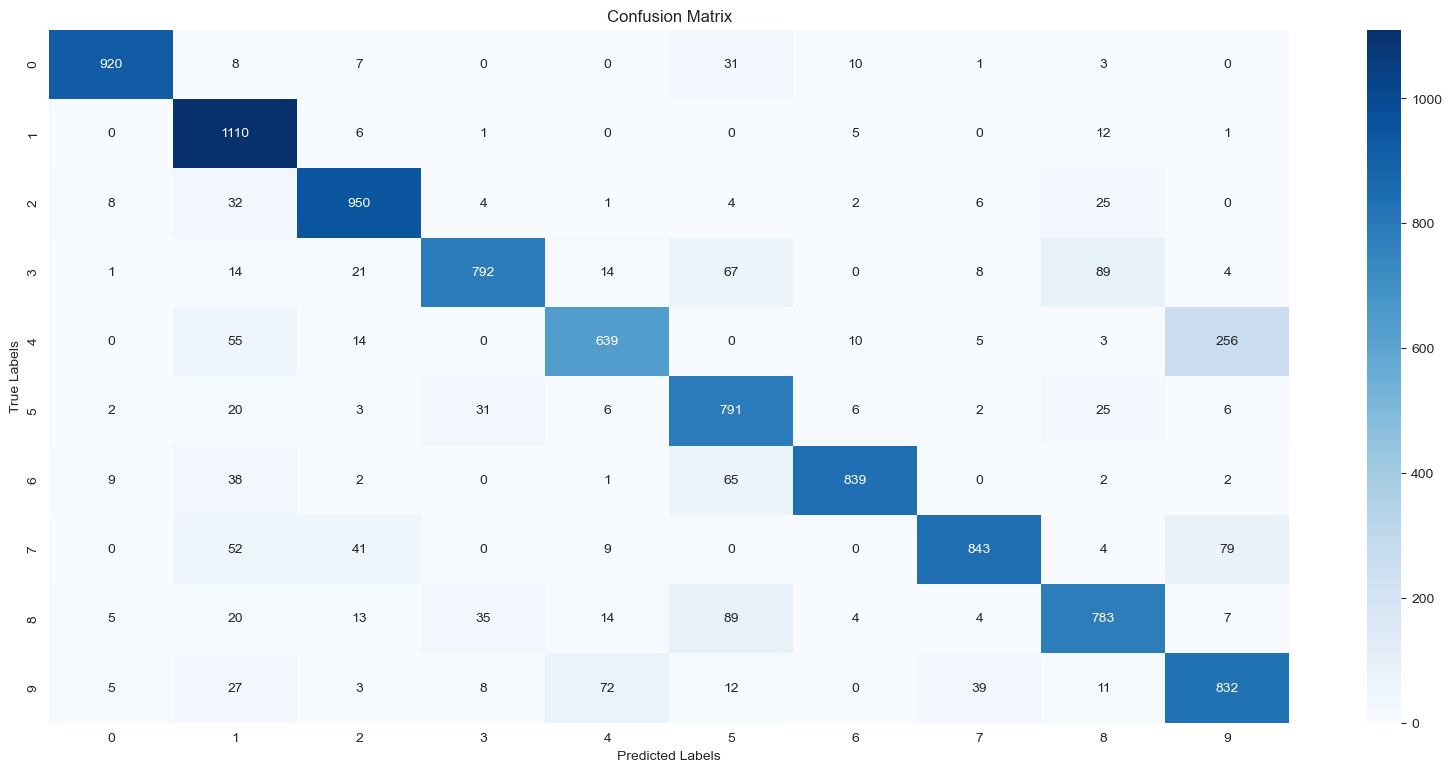

In [98]:
conf_matrix = confusion_matrix(Y_test, rbf_predictions)
plt.figure(figsize=(20,9))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.title("Confusion Matrix")

#### Παρατηρήσεις:
- Το RBF δίκτυο λόγω του clustering χρειάζεται αρκετά περισσότερο χρόνο εκπαίδευσης σε σχέση με KNN και NCC
- Συγκριτικά με το NCC μοντέλο το RBF έχει λίγο καλύτερη απόδοση, αλλά συγκριτικά με τον KNN είναι αρκετά χειρότερος


### Multilayer Perceptron (MLP) Classifier

#### 1. Εκπαίδευση με όλο το Training Data Set

In [125]:
multilayer_perceptron = MLPClassifier(hidden_layer_sizes=(100,),activation="relu",solver="sgd",alpha=0.001,random_state=RANDOM_STATE,verbose=False)
# Fit the model to the training data
start_time = time.time()
multilayer_perceptron.fit(X_train_Normalization,Y_train)
end_time = time.time()
total_time_fit = end_time - start_time

# Make predictions on the test data
start_time = time.time()
multilayer_perceptron_predictions = multilayer_perceptron.predict(X_test_Normalization)
end_time = time.time()
total_time_predict = end_time - start_time

C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [126]:
print(f"Χρόνος εκπαίδευσης: {total_time_fit} seconds.")
print(f"Χρόνος για predictions: {total_time_predict} seconds.")
print('Accuracy on Train: ', accuracy_score(Y_train, multilayer_perceptron.predict(X_train_Normalization)))
print('Accuracy on Test: ', accuracy_score(Y_test, multilayer_perceptron_predictions))

Χρόνος εκπαίδευσης: 139.42679262161255 seconds.
Χρόνος για predictions: 0.042009592056274414 seconds.
Accuracy on Train:  0.9789833333333333
Accuracy on Test:  0.971


#### 2.Εκπαίδευση χρησιμοποιώντας μόνο 1000 δείγματα από όλο το Data Set

In [121]:
multilayer_perceptron = MLPClassifier(hidden_layer_sizes=(100,),activation="relu",solver="sgd",alpha=0.001,random_state=RANDOM_STATE,verbose=True)
# Fit the model to the training data
start_time = time.time()
multilayer_perceptron.fit(X_train_Normalization[:1000],Y_train[:1000])
end_time = time.time()
total_time_fit = end_time - start_time

# Make predictions on the test data
start_time = time.time()
multilayer_perceptron_predictions = multilayer_perceptron.predict(X_test_Normalization)
end_time = time.time()
total_time_predict = end_time - start_time

Iteration 1, loss = 2.35617540
Iteration 2, loss = 2.33183950
Iteration 3, loss = 2.29678343
Iteration 4, loss = 2.25733409
Iteration 5, loss = 2.21554264
Iteration 6, loss = 2.17319574
Iteration 7, loss = 2.13226456
Iteration 8, loss = 2.09232562
Iteration 9, loss = 2.05331376
Iteration 10, loss = 2.01540256
Iteration 11, loss = 1.97823265
Iteration 12, loss = 1.94160674
Iteration 13, loss = 1.90522834
Iteration 14, loss = 1.86955433
Iteration 15, loss = 1.83441080
Iteration 16, loss = 1.79962227
Iteration 17, loss = 1.76480205
Iteration 18, loss = 1.73071407
Iteration 19, loss = 1.69657693
Iteration 20, loss = 1.66317364
Iteration 21, loss = 1.63013626
Iteration 22, loss = 1.59778452
Iteration 23, loss = 1.56597390
Iteration 24, loss = 1.53469746
Iteration 25, loss = 1.50421651
Iteration 26, loss = 1.47430559
Iteration 27, loss = 1.44475524
Iteration 28, loss = 1.41607528
Iteration 29, loss = 1.38802426
Iteration 30, loss = 1.36106719
Iteration 31, loss = 1.33447201
Iteration 32, los

C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [122]:
print(f"Χρόνος εκπαίδευσης: {total_time_fit} seconds.")
print(f"Χρόνος για predictions: {total_time_predict} seconds.")
print('Accuracy on Train: ', accuracy_score(Y_train, multilayer_perceptron.predict(X_train_Normalization)))
print('Accuracy on Test: ', accuracy_score(Y_test, multilayer_perceptron_predictions))

Χρόνος εκπαίδευσης: 2.062899112701416 seconds.
Χρόνος για predictions: 0.0430912971496582 seconds.
Accuracy on Train:  0.8433333333333334
Accuracy on Test:  0.8454


#### Παρατηρούμε ότι το RBF χρειάζεται 60 φορές περισσότερα δεδομένα από το MLP (στο MLP χρησιμοποιούμε το ίδια πλήθος νευρώνων στο κρυφό και στο output layer) για να φτάσει στο ίδιο επίπεδο απόδοσης.

#### Παρακάτω, βλέπουμε δύο πιο καλές εκπαιδεύσεις που πλησιάζουν το 90% accuracy, το οποίο όμως είναι αρκετά πιο κάτω σε σχέση με τις επιδόσεις που πετυχαίνουν το MLP και το KNN.
- Σε αυτό το σημείο να πούμε ότι κατά τη διάρκεια εκπαίδευσης του RBF δικτύου παρατηρήσαμε ότι είναι αρκετά δύσκολο να εκπαιδευτεί ένα RBF.
- Για παράδειγμα, είναι δύσκολο να βρει κανείς το πλήθος των RBF νευρώνων, τα αντίστοιχα κέντρα και πλάτη τους που θα "παίζουν" καλά στο Data Set, καθώς μικρές αλλαγές σε οποιαδήποτε από αυτές τις υπέρ-παραμέτρους προκαλεί σημαντικές αλλαγές στη λειτουργία του δικτύου.
- Παρόλο που η MNIST είναι ένα εύκολο Data Set παρατηρούμε ότι δεν μπορέσαμε να πετύχουμε πολύ υψηλό accuracy.

In [123]:
# Τυχαία επιλογή δειγμάτων από το Data Set ως centroids
rbf_random_centroids = RBFNN2(X_train_Normalization, Y_train, k=1000)

# Fit the model to the training data
start_time = time.time()
rbf_random_centroids.fit()
end_time = time.time()
total_time_fit = end_time - start_time

# Make predictions on the test data
start_time = time.time()
rbf_random_centroids_predictions = rbf_random_centroids.predict(X_test_Normalization)
end_time = time.time()
total_time_predict = end_time - start_time
print(f"Χρόνος εκπαίδευσης: {total_time_fit} seconds.")
print(f"Χρόνος για predictions: {total_time_predict} seconds.")
print('Accuracy on Train: ', accuracy_score(Y_train, rbf_random_centroids.predict(X_train_Normalization)))
print('Accuracy on Test: ', accuracy_score(Y_test, rbf_random_centroids_predictions))

Χρόνος εκπαίδευσης: 421.82014894485474 seconds.
Χρόνος για predictions: 73.24334239959717 seconds.
Accuracy on Train:  0.88995
Accuracy on Test:  0.8942


In [124]:
# Επιλογή 100 training examples από κάθε κλάση ως centroids
rbf_equally_chosen_instances = RBFNN3(X_train_Normalization, Y_train, k=100)

# Fit the model to the training data
start_time = time.time()
rbf_equally_chosen_instances.fit()
end_time = time.time()
total_time_fit = end_time - start_time

# Make predictions on the test data
start_time = time.time()
rbf_equally_chosen_instances_predictions = rbf_equally_chosen_instances.predict(X_test_Normalization)
end_time = time.time()
total_time_predict = end_time - start_time
print(f"Χρόνος εκπαίδευσης: {total_time_fit} seconds.")
print(f"Χρόνος για predictions: {total_time_predict} seconds.")
print('Accuracy on Train: ', accuracy_score(Y_train, rbf_equally_chosen_instances.predict(X_train_Normalization)))
print('Accuracy on Test: ', accuracy_score(Y_test, rbf_equally_chosen_instances_predictions))

Χρόνος εκπαίδευσης: 432.19144463539124 seconds.
Χρόνος για predictions: 68.48296809196472 seconds.
Accuracy on Train:  0.8747166666666667
Accuracy on Test:  0.8732


# 5. Χαρακτηριστικά παραδείγματα ορθής και εσφαλμένης κατηγοριοποίησης

<h3>Παράδειγμα Εσφαλμένης κατηγοριοποίησης</h3>

In [102]:
#Κάνουμε ένα μικρό pre-process για να μπορέσουμε να εντοπίσουμε πιο εύκολα παραδείγματα εσφαλμένης κατηγοριοποίησης

# Ενώνουμε τα X_test και Y_test
Y_test_expanded = np.expand_dims(Y_test,axis=1)
Test_set = np.hstack((X_test_Normalization,Y_test_expanded))
# Μαζεύουμε όλα τα παραδείγματα της κάθε κλάσης μαζί (Δηλαδή στην αρχή του Data Set έχουμε όλα τα training examples με label ίσο με 0, στη συνέχεια όλα τα training examples με label ίσο με 1, κ.ο.κ)
Sorted_test_set = Test_set[Test_set[:, 784].argsort()]
# Κάνουμε split τα X_train και Y_train
Y_test_sorted = Sorted_test_set[:, -1] # for last column
X_test_sorted = Sorted_test_set[:, :-1] # for all but last column

# predictions
rbf_predictions_sorted = rbf.predict(X_test_sorted)

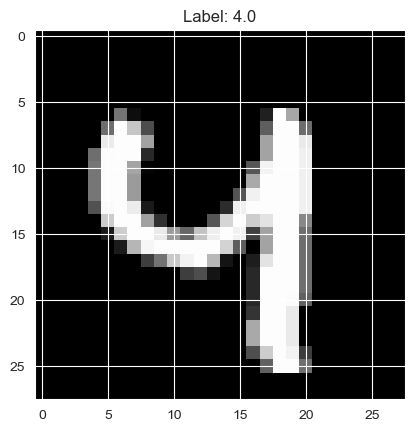

Prediction: 9
Correct Label: 4.0


In [109]:
plt.imshow(np.reshape(X_test_sorted[4732] * 255,(28,28)), cmap='gray', vmin=0, vmax=255)
plt.title(f"Label: {Y_test_sorted[4732]}")
plt.show()
print(f"Prediction: {rbf_predictions_sorted[4732]}")
print(f"Correct Label: {Y_test_sorted[4732]}")

#### Στην εικόνα παρατηρούμε ότι έχουμε ένα 4 που εμείς ως άνθρωποι μπορούμε εύκολα να το κάνουμε σωστά classify, αλλά εδώ το μοντέλο μπερδεύεται πιθανώς λόγω της καμπυλότητας που υπάρχει στην εικόνα και το θεωρεί ως ένα 9.

<h3>Παράδειγμα Ορθής κατηγοριοποίησης</h3>

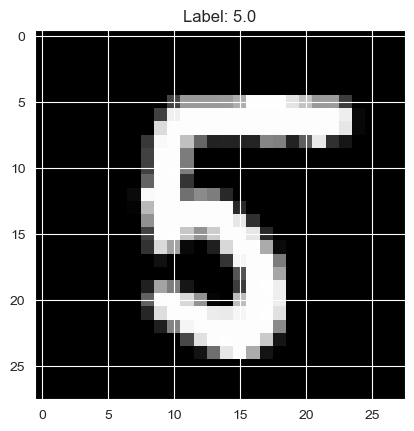

Prediction: 5
Correct Label: 5.0


In [111]:
plt.imshow(np.reshape(X_test_sorted[5395] * 255,(28,28)), cmap='gray', vmin=0, vmax=255)
plt.title(f"Label: {Y_test_sorted[5395]}")
plt.show()
print(f"Prediction: {rbf_predictions_sorted[5395]}")
print(f"Correct Label: {Y_test_sorted[5395]}")

#### Στην εικόνα, παρατηρούμε πως έχουμε ένα 5 το οποίο όμως είναι πολύ κοντά στο να κλείσει τον κύκλο του και να μοιάσει με 6. Παρόλα αυτά το μοντέλο δεν μπερδεύεται και κάνει σωστό classification.